# **Final Version**

This notebook contains only the code that is used for the final version of the model that was presented in class. The original file contains a lot of code for all the different versions that were not presented by show a timeline of how the approach to our models was improved and tuned over time.

## **Model Functions**

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import warnings

In [8]:
warnings.filterwarnings('ignore')

def add_sector_features(stocks_df: pd.DataFrame,
                        companies_df: pd.DataFrame,
                        target_symbol: str) -> pd.DataFrame:
    print(f"Original stocks_df shape: {stocks_df.shape}")

    # Get the sector of our target stock
    target_sector = companies_df.loc[companies_df['Symbol'] == target_symbol, 'Sector'].values[0]
    print(f"Target stock {target_symbol} is in sector: {target_sector}")

    # Get all stocks in the same sector
    sector_companies = companies_df[companies_df['Sector'] == target_sector]
    sector_symbols = sector_companies['Symbol'].tolist()
    print(f"Found {len(sector_symbols)} companies in the {target_sector} sector")

    # Filter stocks_df to only include sector stocks
    sector_stocks = stocks_df[stocks_df['Symbol'].isin(sector_symbols)]
    print(f"Sector stocks data shape: {sector_stocks.shape}")

    # Get only the target stock data
    target_stock_data = stocks_df[stocks_df['Symbol'] == target_symbol].copy()
    print(f"Target stock data shape: {target_stock_data.shape}")

    # Ensure dates are datetime format
    if not pd.api.types.is_datetime64_any_dtype(sector_stocks['Date']):
        sector_stocks['Date'] = pd.to_datetime(sector_stocks['Date'])
        target_stock_data['Date'] = pd.to_datetime(target_stock_data['Date'])

    # Group by date to calculate sector-wide statistics
    sector_daily = sector_stocks.groupby('Date').agg({
        'Close': ['mean', 'std', 'min', 'max', 'median'],
        'Open': ['mean', 'std', 'min', 'max', 'median'],
        'High': ['mean', 'std', 'min', 'max', 'median'],
        'Low': ['mean', 'std', 'min', 'max', 'median']
    })

    # Flatten the column multi-index
    sector_daily.columns = [f'Sector_{col[0]}_{col[1]}' for col in sector_daily.columns]
    print(f"Sector daily aggregates shape: {sector_daily.shape}")

    # Merge sector stats with target stock data
    result = pd.merge(
        target_stock_data,
        sector_daily,
        left_on='Date',
        right_index=True,
        how='left'
    )

    print(f"After merging sector data shape: {result.shape}")

    # Now set Date as index for subsequent operations
    result = result.set_index('Date')

    # Calculate percentage changes for sector aggregates
    for column in ['Sector_Close_mean', 'Sector_Open_mean', 'Sector_High_mean', 'Sector_Low_mean',
                   'Sector_Close_median', 'Sector_Open_median', 'Sector_High_median', 'Sector_Low_median']:
        if column in result.columns:
            result[f'{column}_Pct_Change'] = result[column].pct_change()

    # Step 7: Calculate sector-wide technical indicators
    # RSI for sector mean close
    result['Sector_RSI'] = calculate_rsi(result['Sector_Close_mean'])

    # MACD for sector mean close
    macd_features = calculate_macd(result['Sector_Close_mean'])
    result['Sector_MACD'] = macd_features['MACD']
    result['Sector_MACD_Signal'] = macd_features['MACD_Signal']
    result['Sector_MACD_Hist'] = macd_features['MACD_Hist']

    # Bollinger Bands for sector mean close
    bb_features = calculate_bollinger_bands(result['Sector_Close_mean'])
    result['Sector_BB_Middle'] = bb_features['BB_Middle']
    result['Sector_BB_Upper'] = bb_features['BB_Upper']
    result['Sector_BB_Lower'] = bb_features['BB_Lower']

    # Step 8: Calculate sector momentum over multiple periods
    periods = [1, 3, 5, 7, 14]
    momentum_features = calculate_momentum(result['Sector_Close_mean'], periods)
    for key, value in momentum_features.items():
        result[f'Sector_{key}'] = value

    # Step 9: Check for NaN values and clean up
    print(f"Final dataframe shape after adding sector features: {result.shape}")
    na_counts = result.isna().sum()
    if na_counts.sum() > 0:
        print("NaN values found in columns:")
        print(na_counts[na_counts > 0])
        # Drop rows with NaN values
        result = result.dropna()
        print(f"Shape after removing NaN values: {result.shape}")

    return result


def calculate_rsi(data: pd.Series, periods: int = 14) -> pd.Series:
    """Calculate Relative Strength Index (RSI)"""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0))
    loss = (-delta.where(delta < 0, 0))
    avg_gain = gain.rolling(window=periods).mean()
    avg_loss = loss.rolling(window=periods).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data: pd.Series) -> dict:
    """Calculate Moving Average Convergence Divergence (MACD)"""
    ema_fast = data.ewm(span=12, adjust=False).mean()
    ema_slow = data.ewm(span=26, adjust=False).mean()
    macd_line = ema_fast - ema_slow
    signal_line = macd_line.ewm(span=9, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return {
        'MACD': macd_line,
        'MACD_Signal': signal_line,
        'MACD_Hist': macd_hist
    }

def calculate_bollinger_bands(data: pd.Series) -> dict:
    """Calculate Bollinger Bands"""
    middle_band = data.rolling(window=20).mean()
    std = data.rolling(window=20).std()
    upper_band = middle_band + (std * 2)
    lower_band = middle_band - (std * 2)
    return {
        'BB_Middle': middle_band,
        'BB_Upper': upper_band,
        'BB_Lower': lower_band
    }

def calculate_momentum(data: pd.Series, periods: List[int]) -> dict:
    """Calculate momentum indicators for multiple periods"""
    features = {}
    for period in periods:
        features[f'Momentum_{period}d'] = data.pct_change(periods=period)
        features[f'ROC_{period}d'] = (data - data.shift(period)) / data.shift(period) * 100
    return features

def engineer_both_stock_and_sector_features(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create both individual stock features and keep sector features.

    This combines the individual stock feature engineering with the
    sector features already added to the dataframe.
    """
    # Create a copy to avoid modifying original data
    result = df.copy()

    # Calculate previous day's percentage changes for stock price columns
    price_columns = ['Close', 'Open', 'High', 'Low']
    for column in price_columns:
        result[f'Prev_{column}_Pct_Change'] = df[column].pct_change()

    # Calculate targets for next day
    result['Next_Close_Pct_Change'] = result['Close'].pct_change().shift(-1)
    result['Next_Direction'] = np.where(result['Next_Close_Pct_Change'] > 0, 'Up', 'Down')

    # Calculate standard technical indicators for individual stock
    result['RSI'] = calculate_rsi(df['Close'])

    macd_features = calculate_macd(df['Close'])
    result['MACD'] = macd_features['MACD']
    result['MACD_Signal'] = macd_features['MACD_Signal']
    result['MACD_Hist'] = macd_features['MACD_Hist']

    bb_features = calculate_bollinger_bands(df['Close'])
    result['BB_Middle'] = bb_features['BB_Middle']
    result['BB_Upper'] = bb_features['BB_Upper']
    result['BB_Lower'] = bb_features['BB_Lower']

    # Define periods for rolling stats and momentum
    periods = [1, 3, 5, 7, 14]

    # Calculate momentum for closing price
    momentum_features = calculate_momentum(df['Close'], periods)
    for key, value in momentum_features.items():
        result[key] = value

    # Drop rows with NaN values
    result_cleaned = result.dropna()

    return result_cleaned

def prepare_model_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Prepare feature matrix X and target vector y for modeling
    """
    exclude_columns = [
        'Next_Close_Pct_Change',
        'Next_Direction',
        'Symbol',
        'Close',
        'Open',
        'High',
        'Low',
        'Volume',
        'Adj Close'
    ]

    # Select features (excluding target and excluded columns)
    feature_columns = [col for col in df.columns if col not in exclude_columns]

    X = df[feature_columns]
    y = df['Next_Close_Pct_Change']  # Target is next day's close price percentage change

    return X, y

def create_balanced_bins(y: pd.Series, n_bins: int = 5, samples_per_bin: int = 100) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Create balanced bins for the target variable to address class imbalance.

    Args:
        y: Target series with percentage changes
        n_bins: Number of bins to create
        samples_per_bin: Number of samples to take from each bin

    Returns:
        Tuple of (X_balanced, y_balanced)
    """
    # Get the index of y to maintain alignment with X
    idx = y.index

    # Create a new DataFrame with index and target
    df_target = pd.DataFrame({'target': y}, index=idx)

    # Define bins based on percentiles to get roughly equal sized bins
    if n_bins > 2:
        percentiles = np.linspace(0, 100, n_bins + 1)
        bin_edges = np.percentile(y, percentiles)

        # Ensure unique edges
        bin_edges = np.unique(bin_edges)

        # If we lost some bins due to duplicate edges, adjust n_bins
        n_bins = len(bin_edges) - 1
    else:
        # For binary classification (up/down), just split at 0
        bin_edges = [-np.inf, 0, np.inf]
        n_bins = 2

    # Create bin labels
    bin_labels = [f'bin_{i}' for i in range(n_bins)]

    # Assign bins to each row
    df_target['bin'] = pd.cut(df_target['target'], bins=bin_edges, labels=bin_labels)

    # Sample from each bin
    sampled_indices = []

    for bin_label in bin_labels:
        bin_indices = df_target[df_target['bin'] == bin_label].index

        # Ensure we don't try to sample more than available
        bin_sample_count = min(samples_per_bin, len(bin_indices))

        if bin_sample_count > 0:
            bin_sampled = np.random.choice(bin_indices, size=bin_sample_count, replace=False)
            sampled_indices.extend(bin_sampled)

    # Return the sampled indices
    return sampled_indices

def split_time_series_data(df: pd.DataFrame, feature_columns: List[str],
                          target_column: str = 'Next_Close_Pct_Change',
                          train_size: float = 0.7, val_size: float = 0.15,
                          use_balanced_bins: bool = False,
                          n_bins: int = 5,
                          samples_per_bin: int = 100) -> Tuple:
    """
    Split data into train, validation, and test sets chronologically,
    with optional balanced sampling for training data
    """
    df = df.sort_index()
    n = len(df)

    train_end = int(n * train_size)
    val_end = int(n * (train_size + val_size))

    train_df = df.iloc[:train_end]
    val_df = df.iloc[train_end:val_end]
    test_df = df.iloc[val_end:]

    # Get features and target
    X_train_full = train_df[feature_columns]
    y_train_full = train_df[target_column]

    X_val = val_df[feature_columns]
    y_val = val_df[target_column]

    X_test = test_df[feature_columns]
    y_test = test_df[target_column]

    # Apply balanced sampling if requested
    if use_balanced_bins:
        print("\nApplying balanced bin sampling to training data...")
        sampled_indices = create_balanced_bins(y_train_full, n_bins, samples_per_bin)

        X_train = X_train_full.loc[sampled_indices]
        y_train = y_train_full.loc[sampled_indices]

        # Print distribution info before and after sampling
        print(f"Original training set distribution:")
        print(pd.cut(y_train_full, bins=5).value_counts())

        print(f"\nBalanced training set distribution:")
        print(pd.cut(y_train, bins=5).value_counts())

        print(f"\nSampled {len(X_train)} examples from original {len(X_train_full)} training examples")
    else:
        X_train = X_train_full
        y_train = y_train_full

    print(f"Training set: {len(X_train)} samples ({X_train.index[0]} to {X_train.index[-1]})")
    print(f"Validation set: {len(X_val)} samples ({X_val.index[0] if len(X_val) > 0 else 'N/A'} to {X_val.index[-1] if len(X_val) > 0 else 'N/A'})")
    print(f"Test set: {len(X_test)} samples ({X_test.index[0] if len(X_test) > 0 else 'N/A'} to {X_test.index[-1] if len(X_test) > 0 else 'N/A'})")

    # Optionally visualize balanced sampling
    if use_balanced_bins:
        try:
            visualize_balanced_sampling(y_train_full, y_train)
        except Exception as e:
            print(f"Visualization error (non-critical): {e}")

    return X_train, y_train, X_val, y_val, X_test, y_test

def tune_xgboost_hyperparameters(X_train: pd.DataFrame, y_train: pd.Series,
                               X_val: pd.DataFrame, y_val: pd.Series,
                               param_grid: Optional[Dict] = None) -> Dict:
    """
    Tune XGBoost hyperparameters using a coarse-to-fine approach.

    Args:
        X_train: Training features
        y_train: Training target
        X_val: Validation features
        y_val: Validation target
        param_grid: Optional custom parameter grid, otherwise uses default

    Returns:
        Dict with best parameters
    """
    print("\nTuning XGBoost hyperparameters...")

    # Convert data to DMatrix format for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Initial wide search for max_depth and learning_rate
    if param_grid is None:
        # First round: Coarse search for max_depth
        param_grid = {
            'max_depth': [3, 5, 7, 10, 15, 20],
            'eta': [0.1],  # Fixed learning rate
            'objective': ['reg:squarederror'],
            'eval_metric': ['rmse'],
            'subsample': [0.8],
            'colsample_bytree': [0.8],
            'alpha': [1],
            'lambda': [1]
        }

    results = {}
    best_params = {}

    # Run the grid search
    for max_depth in param_grid['max_depth']:
        params = {
            'max_depth': max_depth,
            'eta': param_grid['eta'][0],
            'objective': param_grid['objective'][0],
            'eval_metric': param_grid['eval_metric'][0],
            'subsample': param_grid['subsample'][0],
            'colsample_bytree': param_grid['colsample_bytree'][0],
            'alpha': param_grid['alpha'][0],
            'lambda': param_grid['lambda'][0]
        }

        # Train the model
        evallist = [(dtrain, 'train'), (dval, 'eval')]
        num_rounds = 100

        # Use early stopping to prevent overfitting
        model = xgb.train(params, dtrain, num_rounds, evallist,
                         early_stopping_rounds=10, verbose_eval=False)

        # Get best score
        best_score = model.best_score
        results[max_depth] = best_score

        print(f"max_depth={max_depth}, Best RMSE: {best_score:.4f}")

    # Find best max_depth
    best_max_depth = min(results, key=results.get)
    best_params['max_depth'] = best_max_depth

    print(f"\nBest max_depth: {best_max_depth}")

    # Visualize max_depth tuning results
    try:
        visualize_hyperparameter_tuning(list(results.keys()), list(results.values()), "max_depth")
    except Exception as e:
        print(f"Visualization error (non-critical): {e}")

    # Second round: Fine-tune around the best max_depth
    nearby_depths = [max(1, best_max_depth - 2),
                    max(1, best_max_depth - 1),
                    best_max_depth,
                    best_max_depth + 1,
                    best_max_depth + 2]

    # Remove duplicates and keep only valid values
    nearby_depths = sorted(list(set([d for d in nearby_depths if d > 0])))

    if len(nearby_depths) > 1:  # Only search if we have multiple values
        print("\nFine-tuning max_depth...")

        fine_results = {}

        for max_depth in nearby_depths:
            params = {
                'max_depth': max_depth,
                'eta': param_grid['eta'][0],
                'objective': param_grid['objective'][0],
                'eval_metric': param_grid['eval_metric'][0],
                'subsample': param_grid['subsample'][0],
                'colsample_bytree': param_grid['colsample_bytree'][0],
                'alpha': param_grid['alpha'][0],
                'lambda': param_grid['lambda'][0]
            }

            # Train the model
            evallist = [(dtrain, 'train'), (dval, 'eval')]
            model = xgb.train(params, dtrain, num_rounds, evallist,
                             early_stopping_rounds=10, verbose_eval=False)

            # Get best score
            best_score = model.best_score
            fine_results[max_depth] = best_score

            print(f"max_depth={max_depth}, Best RMSE: {best_score:.4f}")

        # Find best fine-tuned max_depth
        best_max_depth = min(fine_results, key=fine_results.get)
        best_params['max_depth'] = best_max_depth

        print(f"\nFine-tuned best max_depth: {best_max_depth}")

    # Third round: Search for best learning rate (eta)
    print("\nTuning learning rate (eta)...")

    learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
    eta_results = {}

    for eta in learning_rates:
        params = {
            'max_depth': best_params['max_depth'],
            'eta': eta,
            'objective': param_grid['objective'][0],
            'eval_metric': param_grid['eval_metric'][0],
            'subsample': param_grid['subsample'][0],
            'colsample_bytree': param_grid['colsample_bytree'][0],
            'alpha': param_grid['alpha'][0],
            'lambda': param_grid['lambda'][0]
        }

        # Train the model
        evallist = [(dtrain, 'train'), (dval, 'eval')]
        model = xgb.train(params, dtrain, num_rounds, evallist,
                         early_stopping_rounds=10, verbose_eval=False)

        # Get best score
        best_score = model.best_score
        eta_results[eta] = best_score

        print(f"eta={eta}, Best RMSE: {best_score:.4f}")

    # Find best learning rate
    best_eta = min(eta_results, key=eta_results.get)
    best_params['eta'] = best_eta

    print(f"\nBest learning rate (eta): {best_eta}")

    # Visualize eta tuning results
    visualize_hyperparameter_tuning(
        list(eta_results.keys()),
        list(eta_results.values()),
        param_name="learning_rate"
    )

    # Fourth round: Tune subsample and colsample_bytree
    print("\nTuning subsample and colsample_bytree...")

    sample_params = [0.6, 0.7, 0.8, 0.9, 1.0]
    best_score = float('inf')
    best_subsample = 0.8
    best_colsample = 0.8

    for subsample in sample_params:
        for colsample in sample_params:
            params = {
                'max_depth': best_params['max_depth'],
                'eta': best_params['eta'],
                'objective': param_grid['objective'][0],
                'eval_metric': param_grid['eval_metric'][0],
                'subsample': subsample,
                'colsample_bytree': colsample,
                'alpha': param_grid['alpha'][0],
                'lambda': param_grid['lambda'][0]
            }

            # Train the model
            evallist = [(dtrain, 'train'), (dval, 'eval')]
            model = xgb.train(params, dtrain, num_rounds, evallist,
                             early_stopping_rounds=10, verbose_eval=False)

            # Get best score
            score = model.best_score

            if score < best_score:
                best_score = score
                best_subsample = subsample
                best_colsample = colsample

    best_params['subsample'] = best_subsample
    best_params['colsample_bytree'] = best_colsample

    print(f"Best subsample: {best_subsample}, Best colsample_bytree: {best_colsample}")

    # Final best parameters
    final_params = {
        'max_depth': best_params['max_depth'],
        'eta': best_params['eta'],
        'objective': param_grid['objective'][0],
        'eval_metric': param_grid['eval_metric'][0],
        'subsample': best_params['subsample'],
        'colsample_bytree': best_params['colsample_bytree'],
        'alpha': param_grid['alpha'][0],
        'lambda': param_grid['lambda'][0]
    }

    print("\nFinal best parameters:")
    for param, value in final_params.items():
        print(f"{param}: {value}")

    return final_params

def train_xgboost_model(X_train: pd.DataFrame, y_train: pd.Series,
                       X_val: pd.DataFrame = None, y_val: pd.Series = None,
                       params: Dict = None) -> xgb.Booster:
    """
    Train an XGBoost model for stock prediction
    """
    dtrain = xgb.DMatrix(X_train, label=y_train)

    if params is None:
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'rmse',
            'max_depth': 5,
            'eta': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'alpha': 1,
            'lambda': 1,
            'seed': 42
        }

    num_rounds = 100

    if X_val is not None and y_val is not None:
        dval = xgb.DMatrix(X_val, label=y_val)
        evallist = [(dtrain, 'train'), (dval, 'eval')]
        model = xgb.train(params, dtrain, num_rounds, evallist,
                         early_stopping_rounds=10, verbose_eval=False)
    else:
        model = xgb.train(params, dtrain, num_rounds)

    return model

def predict_and_evaluate(model: xgb.Booster, X_val: pd.DataFrame, y_val: pd.Series) -> Dict:
    """
    Make predictions and evaluate model performance
    """
    dval = xgb.DMatrix(X_val)
    predictions = model.predict(dval)

    # Calculate regression metrics
    mse = mean_squared_error(y_val, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, predictions)
    r2 = r2_score(y_val, predictions)

    # Calculate directional accuracy (up/down)
    actual_direction = np.where(y_val > 0, 1, -1)
    predicted_direction = np.where(predictions > 0, 1, -1)
    direction_accuracy = np.mean(actual_direction == predicted_direction) * 100

    metrics = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Direction_Accuracy': direction_accuracy
    }

    print("\nModel Performance Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return {
        'Predictions': predictions,
        'Actual_Values': y_val.values,
        'Metrics': metrics
    }

def plot_results(predictions: np.ndarray, actual_values: np.ndarray, title: str = 'Model Performance'):
    """
    Plot actual vs predicted values with improved axis scaling
    """
    plt.figure(figsize=(15, 10))

    # Time series plot
    plt.subplot(2, 2, 1)
    plt.plot(actual_values, label='Actual', alpha=0.7)
    plt.plot(predictions, label='Predicted', alpha=0.7)
    plt.title('Actual vs Predicted Returns')
    plt.xlabel('Time')
    plt.ylabel('Percentage Change')
    plt.legend()
    plt.grid(True)

    # Scatter plot with improved scaling
    plt.subplot(2, 2, 2)
    plt.scatter(actual_values, predictions, alpha=0.5)

    # Calculate reasonable axis limits based on data
    # Find the 99th percentile to exclude extreme outliers
    x_99 = np.percentile(np.abs(actual_values), 99)
    y_99 = np.percentile(np.abs(predictions), 99)

    # Use the larger of the two for symmetrical axes
    limit = max(x_99, y_99) * 1.1  # Add 10% padding

    # Set axis limits
    plt.xlim(-limit, limit)
    plt.ylim(-limit, limit)

    # Add perfect prediction line
    plt.plot([-limit, limit], [-limit, limit], 'r--')

    # Add quadrant lines
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.3)

    plt.xlabel('Actual Returns')
    plt.ylabel('Predicted Returns')
    plt.title('Scatter Plot of Predictions')
    plt.grid(True)

    # Distribution of actual and predicted values
    plt.subplot(2, 2, 3)
    plt.hist(actual_values, bins=50, alpha=0.5, label='Actual')
    plt.hist(predictions, bins=50, alpha=0.5, label='Predicted')
    plt.xlabel('Percentage Change')
    plt.ylabel('Frequency')
    plt.title('Distribution of Actual vs Predicted Values')
    plt.legend()
    plt.grid(True)

    # Error distribution
    plt.subplot(2, 2, 4)
    errors = actual_values - predictions
    plt.hist(errors, bins=50)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.grid(True)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.92)
    plt.show()

def plot_feature_importance(model: xgb.Booster, feature_names: List[str], top_n: int = 20):
    """
    Plot feature importance from XGBoost model with improved error handling
    """
    try:
        # Get importance scores directly from model
        importance = model.get_score(importance_type='weight')

        # Check if we got any importance scores
        if not importance:
            print("Warning: No feature importance returned by the model.")
            return pd.DataFrame(columns=['Feature', 'Importance'])  # Return empty DataFrame with expected columns

        # Convert to DataFrame for easier manipulation
        importance_df = pd.DataFrame({
            'Feature': list(importance.keys()),
            'Importance': list(importance.values())
        }).sort_values('Importance', ascending=False)

        # Limit to top_n features
        if len(importance_df) > top_n:
            importance_df = importance_df.head(top_n)

        plt.figure(figsize=(12, 8))
        plt.barh(importance_df['Feature'][::-1], importance_df['Importance'][::-1])
        plt.xlabel('Feature Importance (Weight)')
        plt.title(f'Top {len(importance_df)} Important Features')
        plt.tight_layout()
        plt.show()

        return importance_df
    except Exception as e:
        print(f"Error plotting feature importance: {e}")
        return pd.DataFrame(columns=['Feature', 'Importance'])  # Return empty DataFrame with expected columns

def run_sector_based_prediction_with_balanced_data(stocks_df: pd.DataFrame,
                                                 companies_df: pd.DataFrame,
                                                 target_symbol: str,
                                                 use_balanced_bins: bool = True,
                                                 n_bins: int = 5,
                                                 samples_per_bin: int = 100,
                                                 tune_hyperparameters: bool = True):
    """
    Run the complete sector-based stock prediction workflow with balanced data sampling
    and hyperparameter tuning.

    Args:
        stocks_df: DataFrame with stock data
        companies_df: DataFrame with company metadata
        target_symbol: Symbol of the stock to predict
        use_balanced_bins: Whether to use balanced bin sampling
        n_bins: Number of bins for balanced sampling
        samples_per_bin: Number of samples to take from each bin
        tune_hyperparameters: Whether to tune XGBoost hyperparameters

    Returns:
        Dict with results
    """
    print(f"\n{'='*50}")
    print(f"Starting sector-based prediction for {target_symbol}")
    print(f"{'='*50}")

    # Step 1: Add sector features to the target stock data
    stock_with_sector = add_sector_features(stocks_df, companies_df, target_symbol)

    # Step 2: Engineer individual stock features while keeping sector features
    feature_df = engineer_both_stock_and_sector_features(stock_with_sector)

    # Step 3: Prepare data for modeling
    X, y = prepare_model_data(feature_df)

    # Step 4: Split data into train, validation, and test sets with balanced sampling
    X_train, y_train, X_val, y_val, X_test, y_test = split_time_series_data(
        feature_df, X.columns, use_balanced_bins=use_balanced_bins,
        n_bins=n_bins, samples_per_bin=samples_per_bin
    )

    # Step 5: Optionally tune hyperparameters
    if tune_hyperparameters:
        print("\nTuning XGBoost hyperparameters...")
        best_params = tune_xgboost_hyperparameters(X_train, y_train, X_val, y_val)
    else:
        best_params = None

    # Step 6: Train XGBoost model with best parameters
    print("\nTraining XGBoost model...")
    model = train_xgboost_model(X_train, y_train, X_val, y_val, params=best_params)

    # Step 7: Evaluate on validation set
    print("\nEvaluating on validation set...")
    val_results = predict_and_evaluate(model, X_val, y_val)

    # Step 8: Plot validation results
    plot_results(val_results['Predictions'], val_results['Actual_Values'],
                title=f'{target_symbol} Validation Results')

    # Step 9: Plot feature importance
    importance_df = plot_feature_importance(model, X.columns)

    # Step 10: Evaluate on test set
    print("\nEvaluating on test set...")
    test_results = predict_and_evaluate(model, X_test, y_test)

    # Step 11: Plot test results
    plot_results(test_results['Predictions'], test_results['Actual_Values'],
                title=f'{target_symbol} Test Results')

    # Analyze sector vs. individual feature importance
    sector_features = [col for col in importance_df['Feature'] if col.startswith('Sector_')]
    individual_features = [col for col in importance_df['Feature'] if not col.startswith('Sector_')]

    if not sector_features or not individual_features:
        print("\nWarning: Could not separate sector and individual features in importance list.")
    else:
        sector_importance = importance_df[importance_df['Feature'].isin(sector_features)]['Importance'].sum()
        individual_importance = importance_df[importance_df['Feature'].isin(individual_features)]['Importance'].sum()

        print(f"\nSector features total importance: {sector_importance:.2f}")
        print(f"Individual features total importance: {individual_importance:.2f}")
        print(f"Ratio of sector to individual importance: {sector_importance/individual_importance:.2f}")

    # Compare balance approach with original approach if using balanced bins
    if use_balanced_bins:
        print("\n\nComparing balanced approach with original approach...")

        # Train model without balanced sampling
        X_train_orig, y_train_orig, X_val, y_val, X_test, y_test = split_time_series_data(
            feature_df, X.columns, use_balanced_bins=False
        )

        # Train original model (without balancing)
        print("\nTraining model without balanced sampling...")
        orig_model = train_xgboost_model(X_train_orig, y_train_orig, X_val, y_val, params=best_params)

        # Evaluate original model
        orig_results = predict_and_evaluate(orig_model, X_val, y_val)

        # Print comparison
        print("\nBalanced vs. Original Model Comparison:")
        print(f"{'Metric':<20} {'Balanced':<10} {'Original':<10} {'Difference':<10}")
        print("-" * 50)

        for metric in ['MSE', 'RMSE', 'MAE', 'R2', 'Direction_Accuracy']:
            balanced_value = val_results['Metrics'][metric]
            orig_value = orig_results['Metrics'][metric]

            if metric in ['R2', 'Direction_Accuracy']:  # Higher is better
                diff = balanced_value - orig_value
                diff_str = f"+{diff:.4f}" if diff > 0 else f"{diff:.4f}"
            else:  # Lower is better
                diff = orig_value - balanced_value
                diff_str = f"+{diff:.4f}" if diff > 0 else f"{diff:.4f}"

            print(f"{metric:<20} {balanced_value:<10.4f} {orig_value:<10.4f} {diff_str:<10}")

    return {
        'model': model,
        'validation_results': val_results,
        'test_results': test_results,
        'feature_importance': importance_df,
        'best_params': best_params if tune_hyperparameters else None
    }

def visualize_balanced_sampling(y_train_full, y_train):
    """Simple histogram visualization of balanced sampling effect"""
    plt.figure(figsize=(12, 5))

    # Create subplot for original distribution
    plt.subplot(1, 2, 1)
    plt.hist(y_train_full, bins=30, alpha=0.7, color='blue')
    plt.title('Original Data Distribution')
    plt.xlabel('Daily Returns')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.3)

    # Create subplot for balanced distribution
    plt.subplot(1, 2, 2)
    plt.hist(y_train, bins=30, alpha=0.7, color='green')
    plt.title('Balanced Data Distribution')
    plt.xlabel('Daily Returns')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

def visualize_hyperparameter_tuning(param_values, scores, param_name="max_depth"):
    """Simple line plot for hyperparameter tuning results"""
    plt.figure(figsize=(10, 6))

    # Convert inputs to lists if they're dictionaries
    if isinstance(param_values, dict) and isinstance(scores, dict):
        x_values = list(param_values.keys())
        y_values = list(param_values.values())
    else:
        x_values = param_values
        y_values = scores

    # Create the plot
    plt.plot(x_values, y_values, 'o-', linewidth=2, markersize=10)

    # Mark the best value
    best_idx = np.argmin(y_values)
    best_x = x_values[best_idx]
    best_y = y_values[best_idx]

    plt.scatter([best_x], [best_y], s=200, c='red', marker='*')

    # Add labels and title
    plt.xlabel(f'{param_name} Value')
    plt.ylabel('Error (RMSE)')
    plt.title(f'Finding Optimal {param_name} Value')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_directional_accuracy_comparison(results_dict):
    """Create a bar chart comparing directional accuracy"""
    # Define models and their colors
    models = ['Random Guessing', 'Original + Tuned', 'Balanced + Untuned', 'Balanced + Tuned']
    colors = ['lightgray', 'skyblue', 'lightgreen', 'green']

    # Set accuracy values
    accuracy = [50.0]  # Random guessing baseline

    # Add actual values from results
    for model in models[1:]:
        accuracy.append(results_dict.get(model, np.nan))

    # Create bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(models, accuracy, color=colors)

    # Add horizontal line for baseline
    plt.axhline(y=50, color='red', linestyle='--')

    # Customize chart
    plt.ylabel('Directional Accuracy (%)')
    plt.title('Model Performance Comparison')
    plt.grid(axis='y', alpha=0.3)

    # Set y-axis to better show small differences
    plt.ylim(49, 54)

    plt.tight_layout()
    plt.show()

## **Test Model**

Loading data...


========== EXPERIMENT 1: BALANCED BINS WITH HYPERPARAMETER TUNING ==========

Starting sector-based prediction for MMM
Original stocks_df shape: (1870154, 8)
Target stock MMM is in sector: Industrials
Found 69 companies in the Industrials sector
Sector stocks data shape: (256542, 8)
Target stock data shape: (3718, 8)
Sector daily aggregates shape: (3718, 20)
After merging sector data shape: (3718, 28)
Final dataframe shape after adding sector features: (3718, 52)
NaN values found in columns:
Sector_Close_mean_Pct_Change       1
Sector_Open_mean_Pct_Change        1
Sector_High_mean_Pct_Change        1
Sector_Low_mean_Pct_Change         1
Sector_Close_median_Pct_Change     1
Sector_Open_median_Pct_Change      1
Sector_High_median_Pct_Change      1
Sector_Low_median_Pct_Change       1
Sector_RSI                        13
Sector_BB_Middle                  19
Sector_BB_Upper                   19
Sector_BB_Lower                   19
Sector_Momentum_1d                 1
Sect

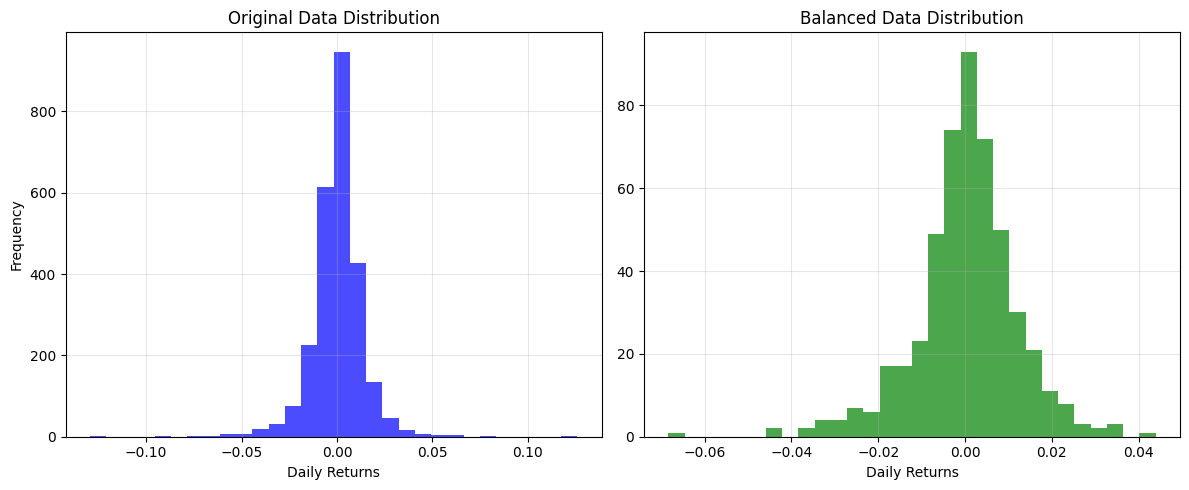


Tuning XGBoost hyperparameters...

Tuning XGBoost hyperparameters...
max_depth=3, Best RMSE: 0.0140
max_depth=5, Best RMSE: 0.0140
max_depth=7, Best RMSE: 0.0140
max_depth=10, Best RMSE: 0.0140
max_depth=15, Best RMSE: 0.0140
max_depth=20, Best RMSE: 0.0140

Best max_depth: 3


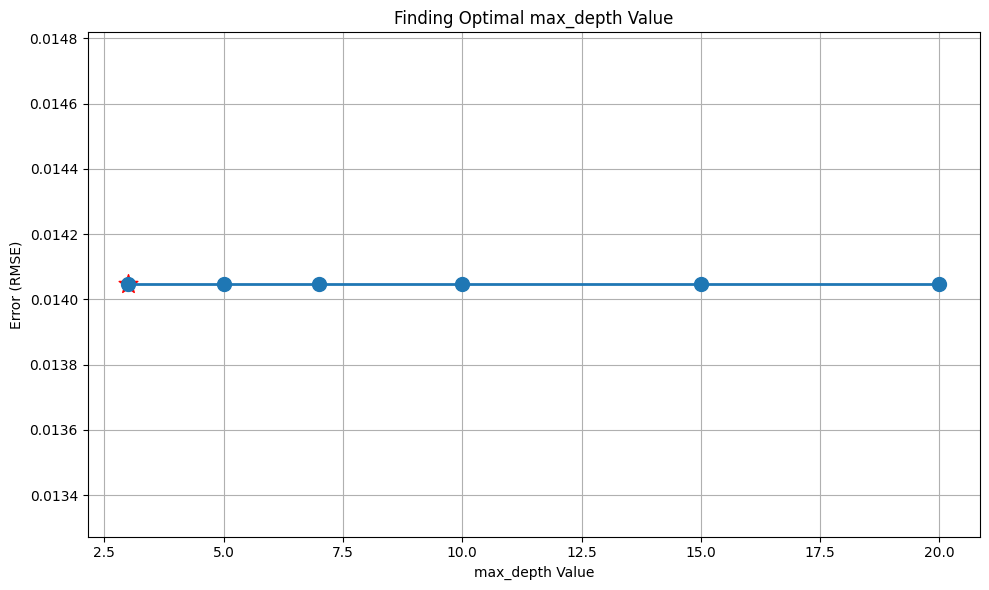


Fine-tuning max_depth...
max_depth=1, Best RMSE: 0.0140
max_depth=2, Best RMSE: 0.0140
max_depth=3, Best RMSE: 0.0140
max_depth=4, Best RMSE: 0.0140
max_depth=5, Best RMSE: 0.0140

Fine-tuned best max_depth: 1

Tuning learning rate (eta)...
eta=0.01, Best RMSE: 0.0140
eta=0.05, Best RMSE: 0.0140
eta=0.1, Best RMSE: 0.0140
eta=0.2, Best RMSE: 0.0140
eta=0.3, Best RMSE: 0.0140

Best learning rate (eta): 0.01


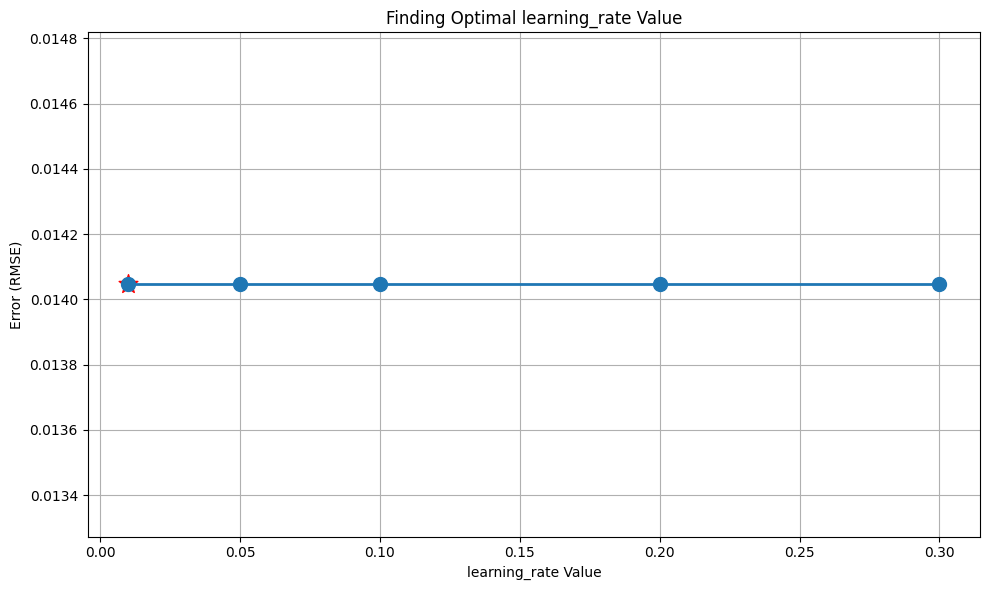


Tuning subsample and colsample_bytree...
Best subsample: 0.6, Best colsample_bytree: 0.6

Final best parameters:
max_depth: 1
eta: 0.01
objective: reg:squarederror
eval_metric: rmse
subsample: 0.6
colsample_bytree: 0.6
alpha: 1
lambda: 1

Training XGBoost model...

Evaluating on validation set...

Model Performance Metrics:
MSE: 0.0002
RMSE: 0.0140
MAE: 0.0103
R2: -0.0001
Direction_Accuracy: 52.5362


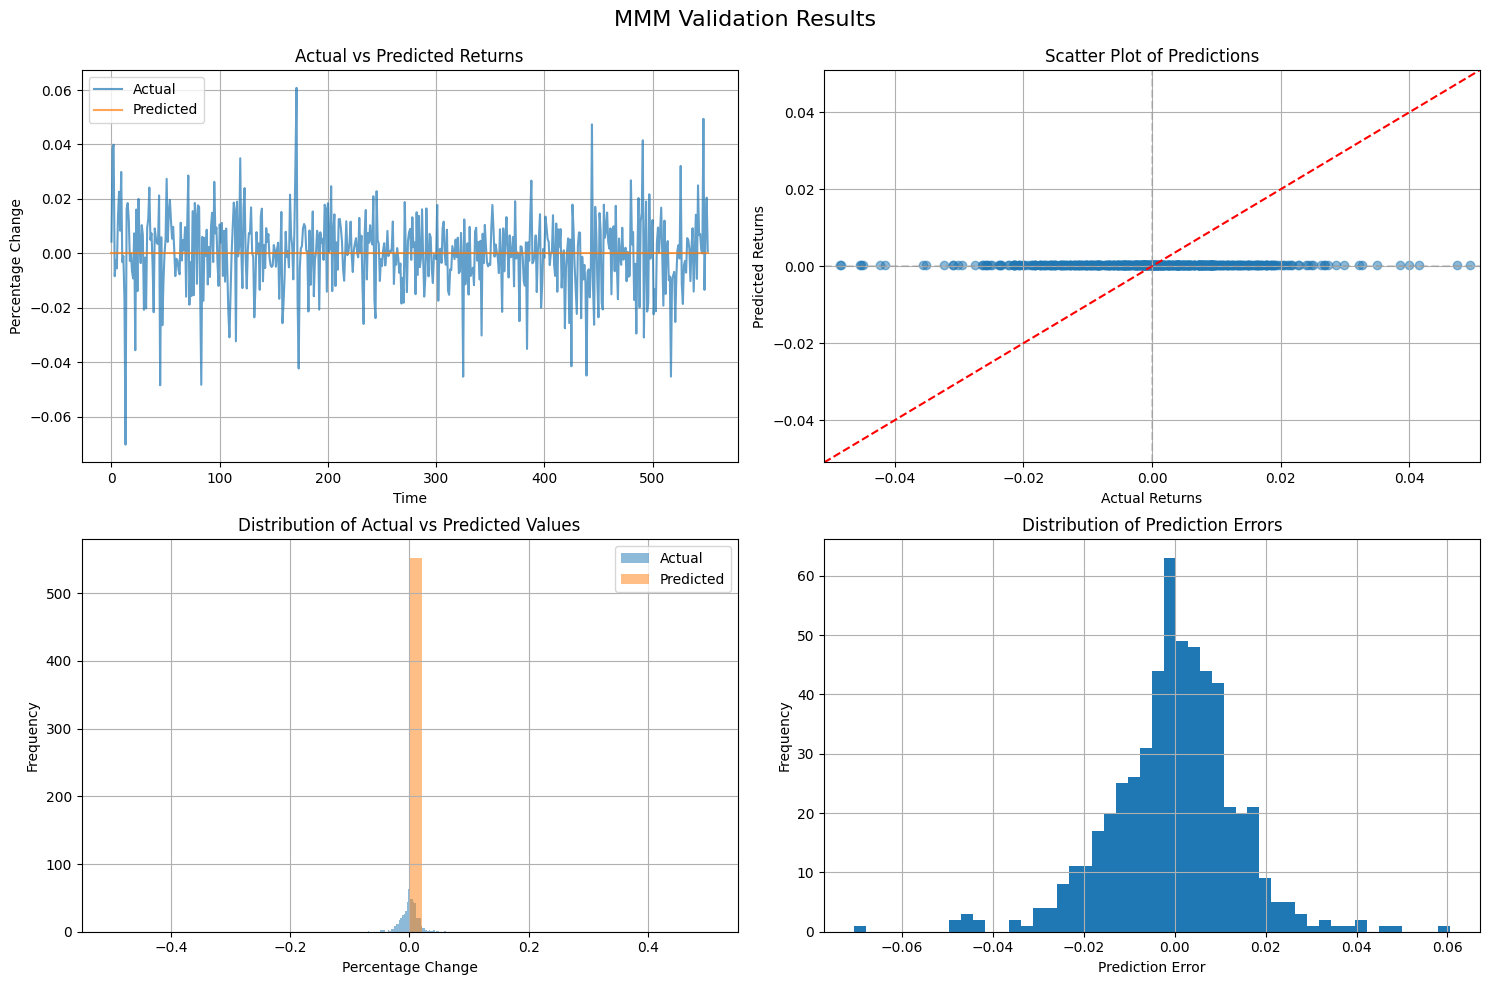


Evaluating on test set...

Model Performance Metrics:
MSE: 0.0004
RMSE: 0.0197
MAE: 0.0124
R2: -0.0001
Direction_Accuracy: 48.1884


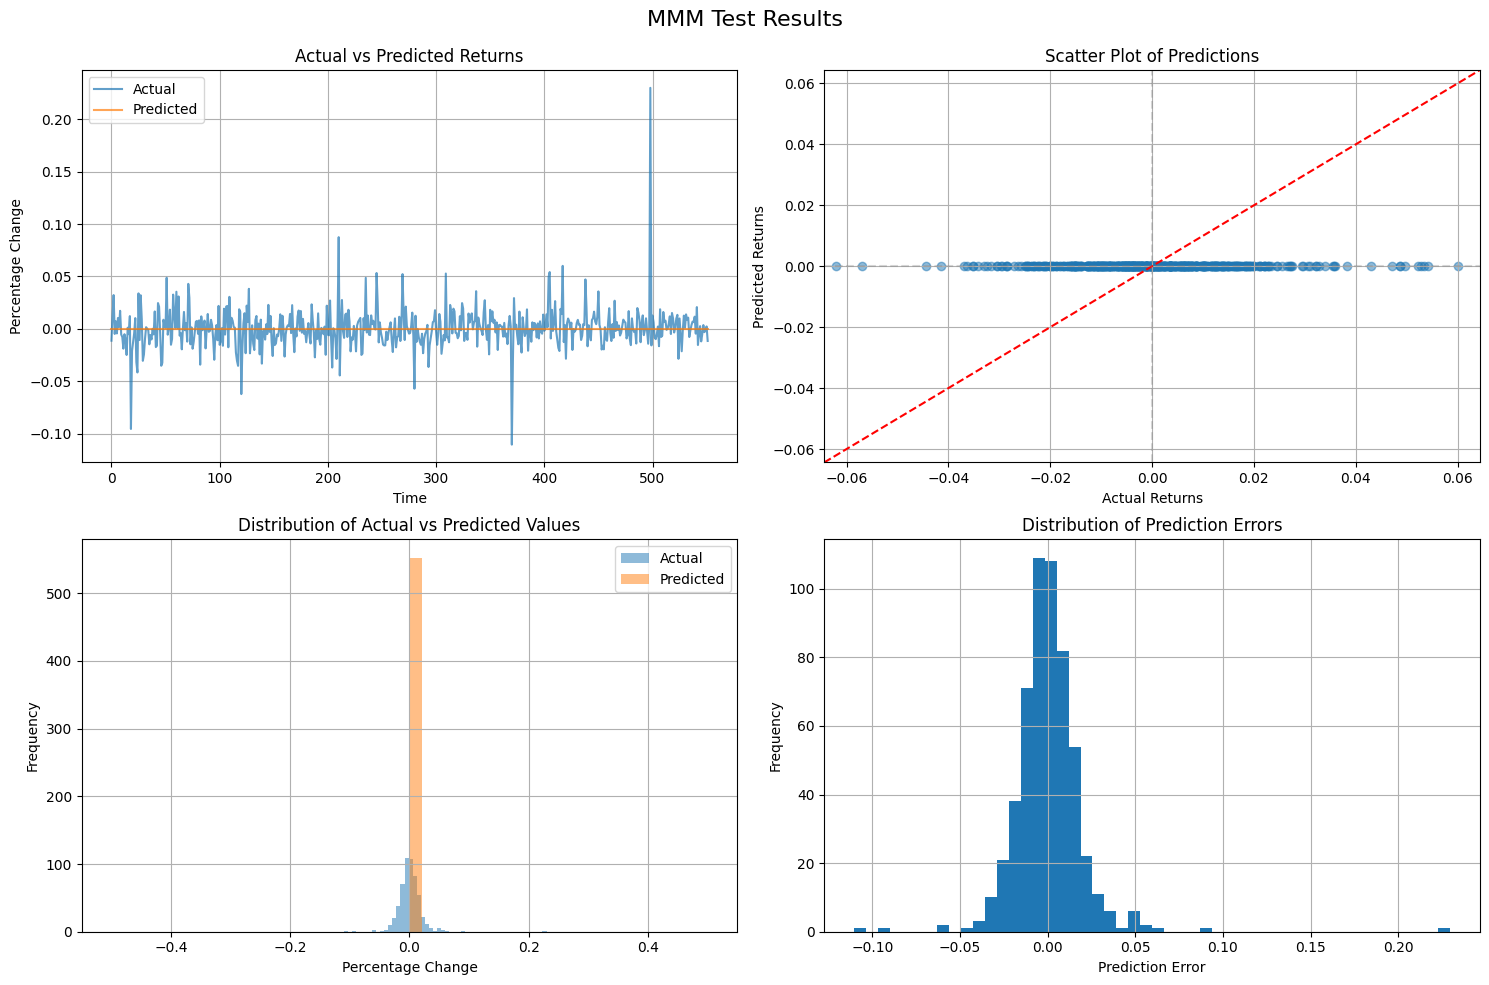




Comparing balanced approach with original approach...
Training set: 2575 samples (2010-03-01 00:00:00 to 2020-05-20 00:00:00)
Validation set: 552 samples (2020-05-21 00:00:00 to 2022-07-29 00:00:00)
Test set: 552 samples (2022-08-01 00:00:00 to 2024-10-09 00:00:00)

Training model without balanced sampling...

Model Performance Metrics:
MSE: 0.0002
RMSE: 0.0140
MAE: 0.0102
R2: -0.0003
Direction_Accuracy: 52.5362

Balanced vs. Original Model Comparison:
Metric               Balanced   Original   Difference
--------------------------------------------------
MSE                  0.0002     0.0002     +0.0000   
RMSE                 0.0140     0.0140     +0.0000   
MAE                  0.0103     0.0102     -0.0000   
R2                   -0.0001    -0.0003    +0.0002   
Direction_Accuracy   52.5362    52.5362    0.0000    


========== EXPERIMENT 2: BALANCED BINS WITHOUT HYPERPARAMETER TUNING ==========

Starting sector-based prediction for MMM
Original stocks_df shape: (1870154, 8)
Ta

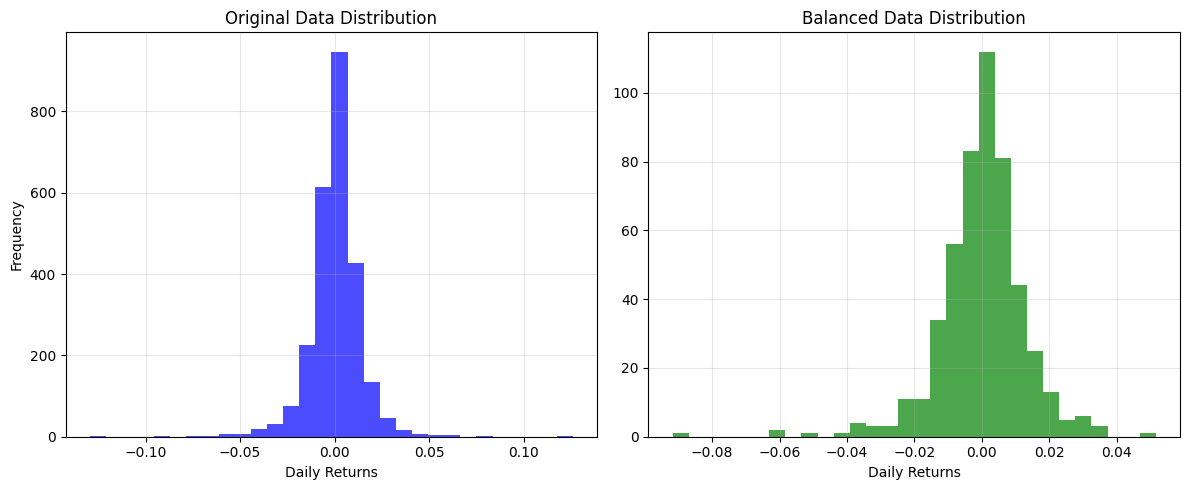


Training XGBoost model...

Evaluating on validation set...

Model Performance Metrics:
MSE: 0.0002
RMSE: 0.0140
MAE: 0.0103
R2: -0.0000
Direction_Accuracy: 52.5362


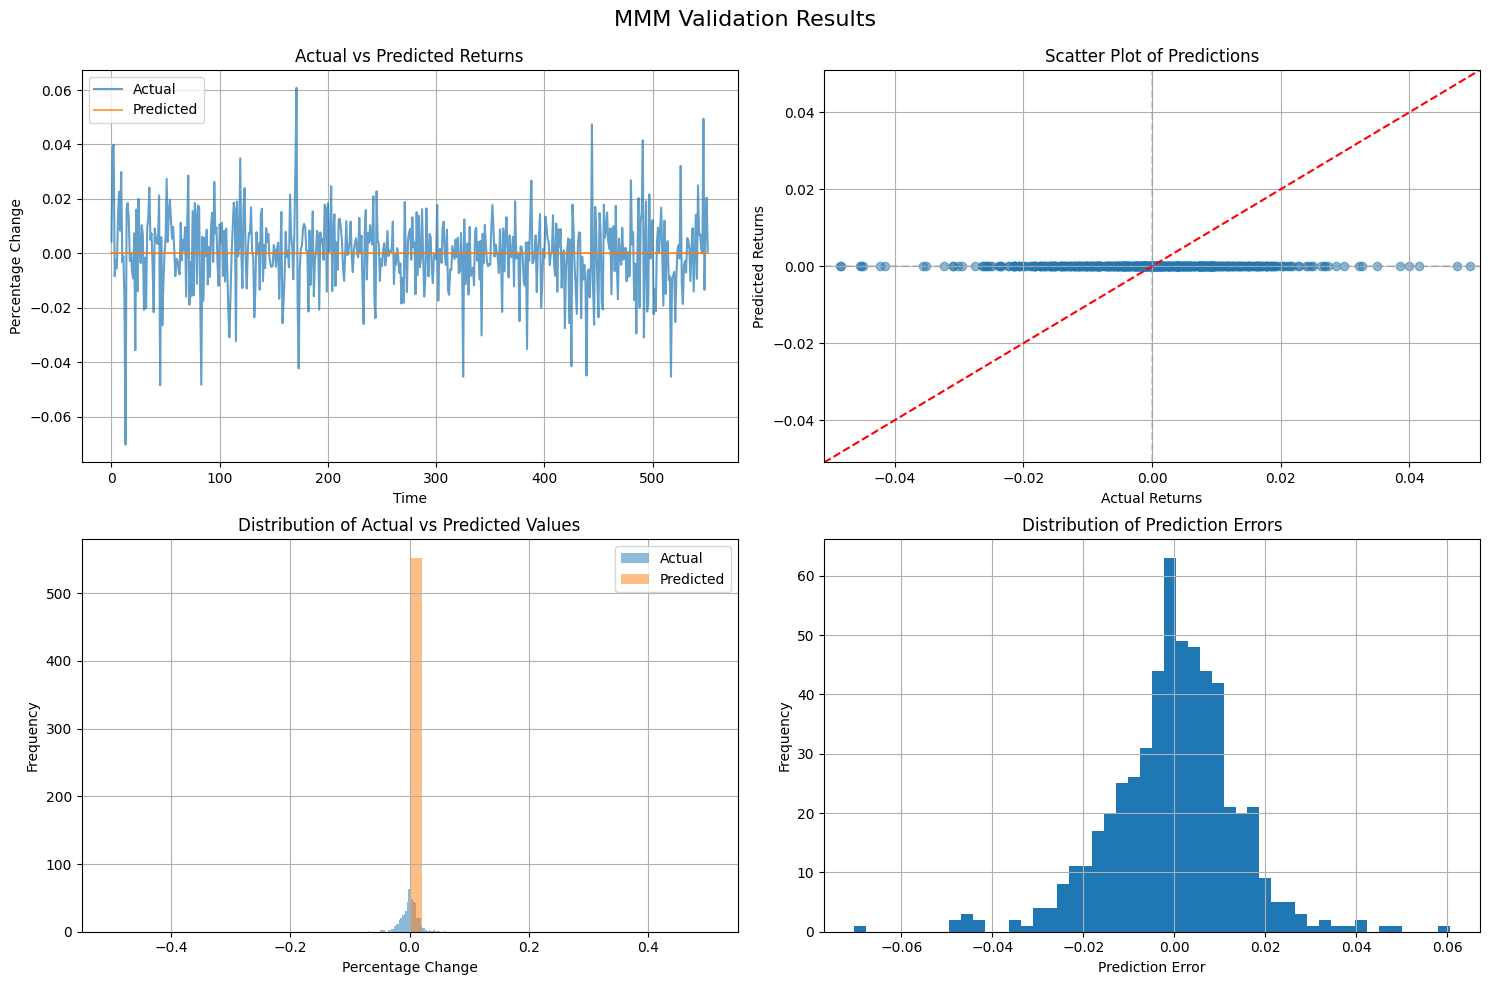


Evaluating on test set...

Model Performance Metrics:
MSE: 0.0004
RMSE: 0.0197
MAE: 0.0124
R2: -0.0002
Direction_Accuracy: 48.1884


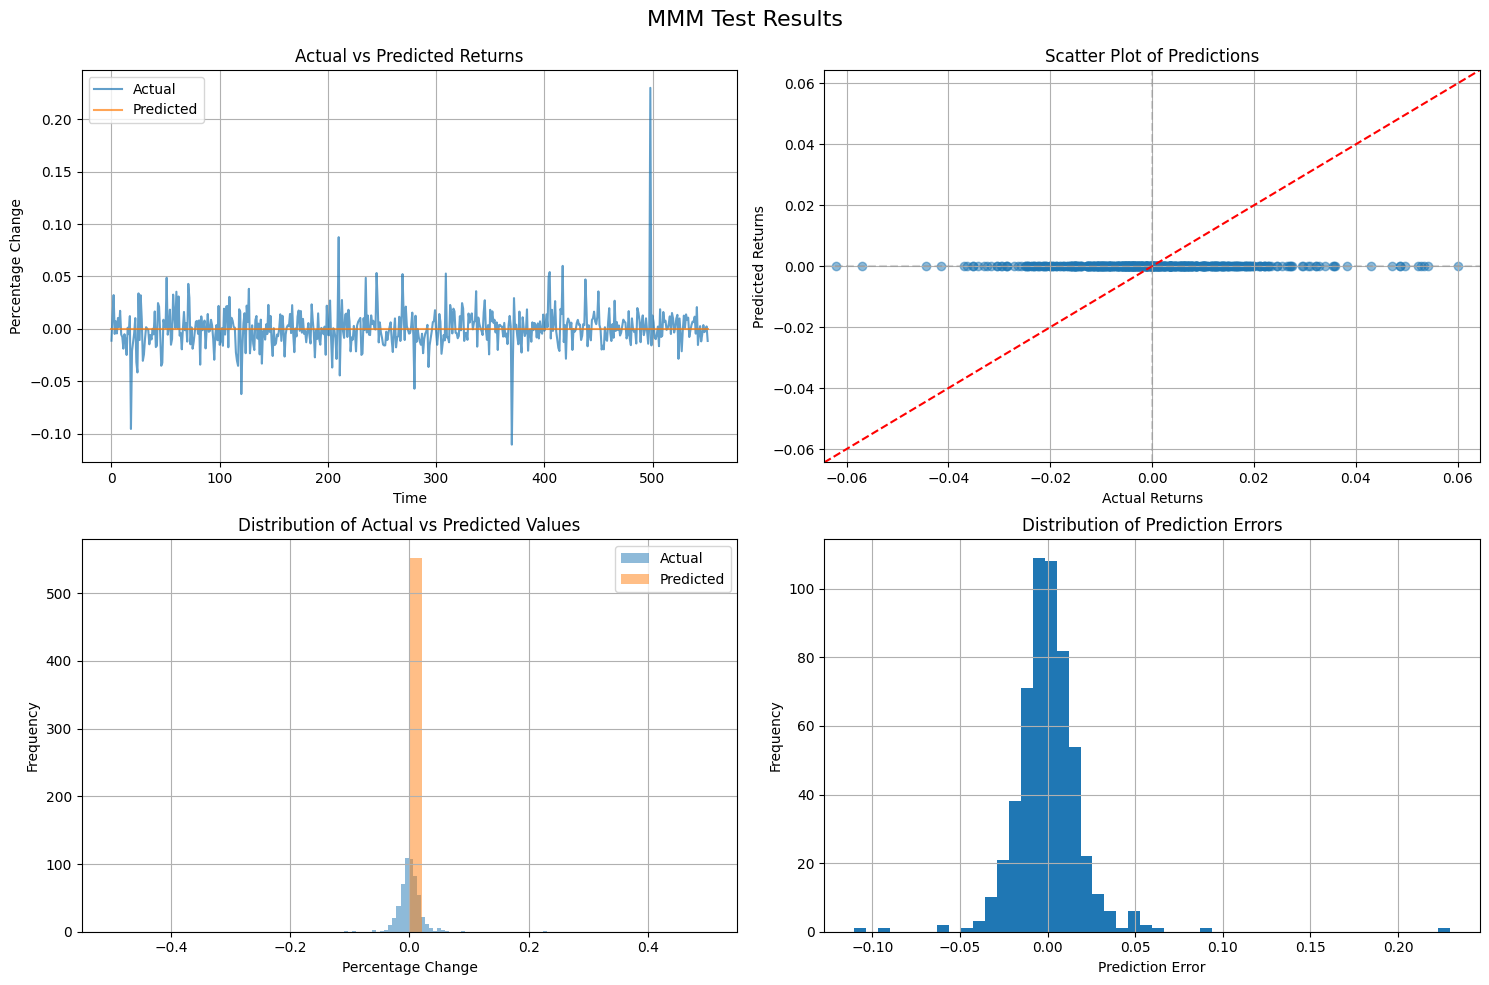




Comparing balanced approach with original approach...
Training set: 2575 samples (2010-03-01 00:00:00 to 2020-05-20 00:00:00)
Validation set: 552 samples (2020-05-21 00:00:00 to 2022-07-29 00:00:00)
Test set: 552 samples (2022-08-01 00:00:00 to 2024-10-09 00:00:00)

Training model without balanced sampling...

Model Performance Metrics:
MSE: 0.0002
RMSE: 0.0140
MAE: 0.0102
R2: 0.0007
Direction_Accuracy: 52.5362

Balanced vs. Original Model Comparison:
Metric               Balanced   Original   Difference
--------------------------------------------------
MSE                  0.0002     0.0002     -0.0000   
RMSE                 0.0140     0.0140     -0.0000   
MAE                  0.0103     0.0102     -0.0000   
R2                   -0.0000    0.0007     -0.0007   
Direction_Accuracy   52.5362    52.5362    0.0000    


========== EXPERIMENT 3: ORIGINAL DISTRIBUTION WITH HYPERPARAMETER TUNING ==========

Starting sector-based prediction for MMM
Original stocks_df shape: (1870154, 8

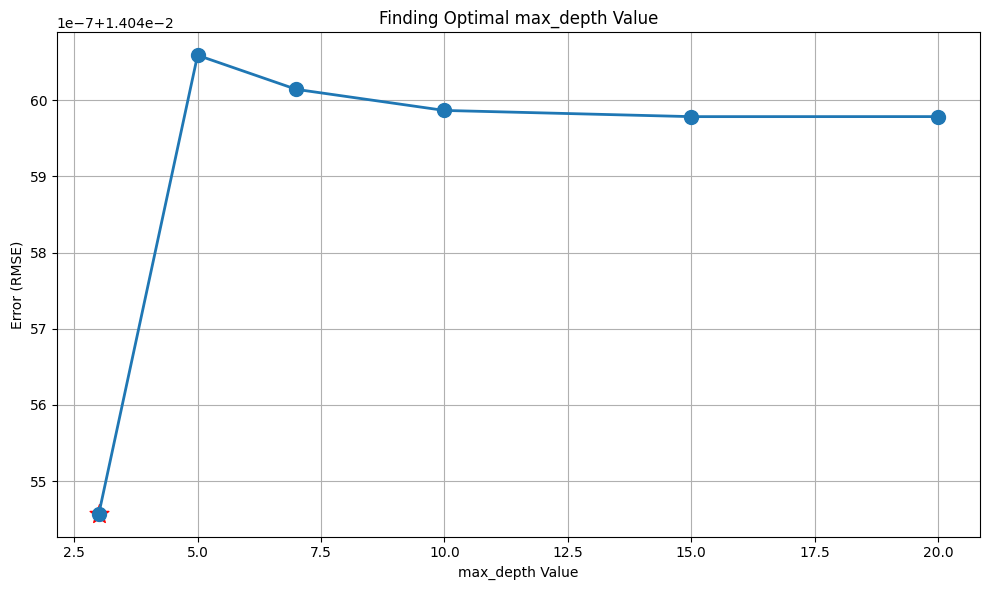


Fine-tuning max_depth...
max_depth=1, Best RMSE: 0.0140
max_depth=2, Best RMSE: 0.0140
max_depth=3, Best RMSE: 0.0140
max_depth=4, Best RMSE: 0.0140
max_depth=5, Best RMSE: 0.0140

Fine-tuned best max_depth: 3

Tuning learning rate (eta)...
eta=0.01, Best RMSE: 0.0140
eta=0.05, Best RMSE: 0.0140
eta=0.1, Best RMSE: 0.0140
eta=0.2, Best RMSE: 0.0140
eta=0.3, Best RMSE: 0.0140

Best learning rate (eta): 0.3


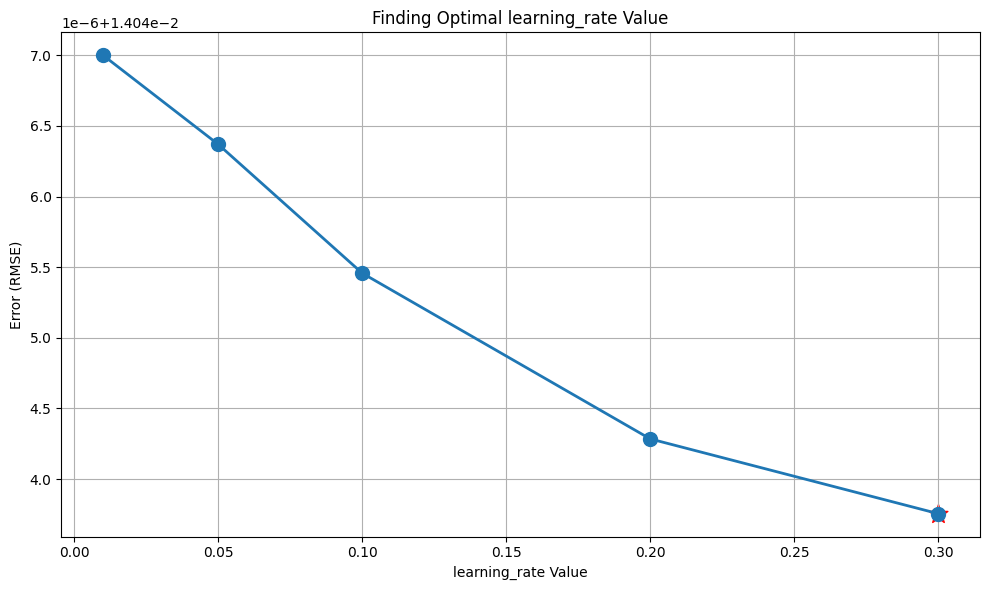


Tuning subsample and colsample_bytree...
Best subsample: 0.7, Best colsample_bytree: 0.9

Final best parameters:
max_depth: 3
eta: 0.3
objective: reg:squarederror
eval_metric: rmse
subsample: 0.7
colsample_bytree: 0.9
alpha: 1
lambda: 1

Training XGBoost model...

Evaluating on validation set...

Model Performance Metrics:
MSE: 0.0002
RMSE: 0.0140
MAE: 0.0102
R2: 0.0009
Direction_Accuracy: 51.9928


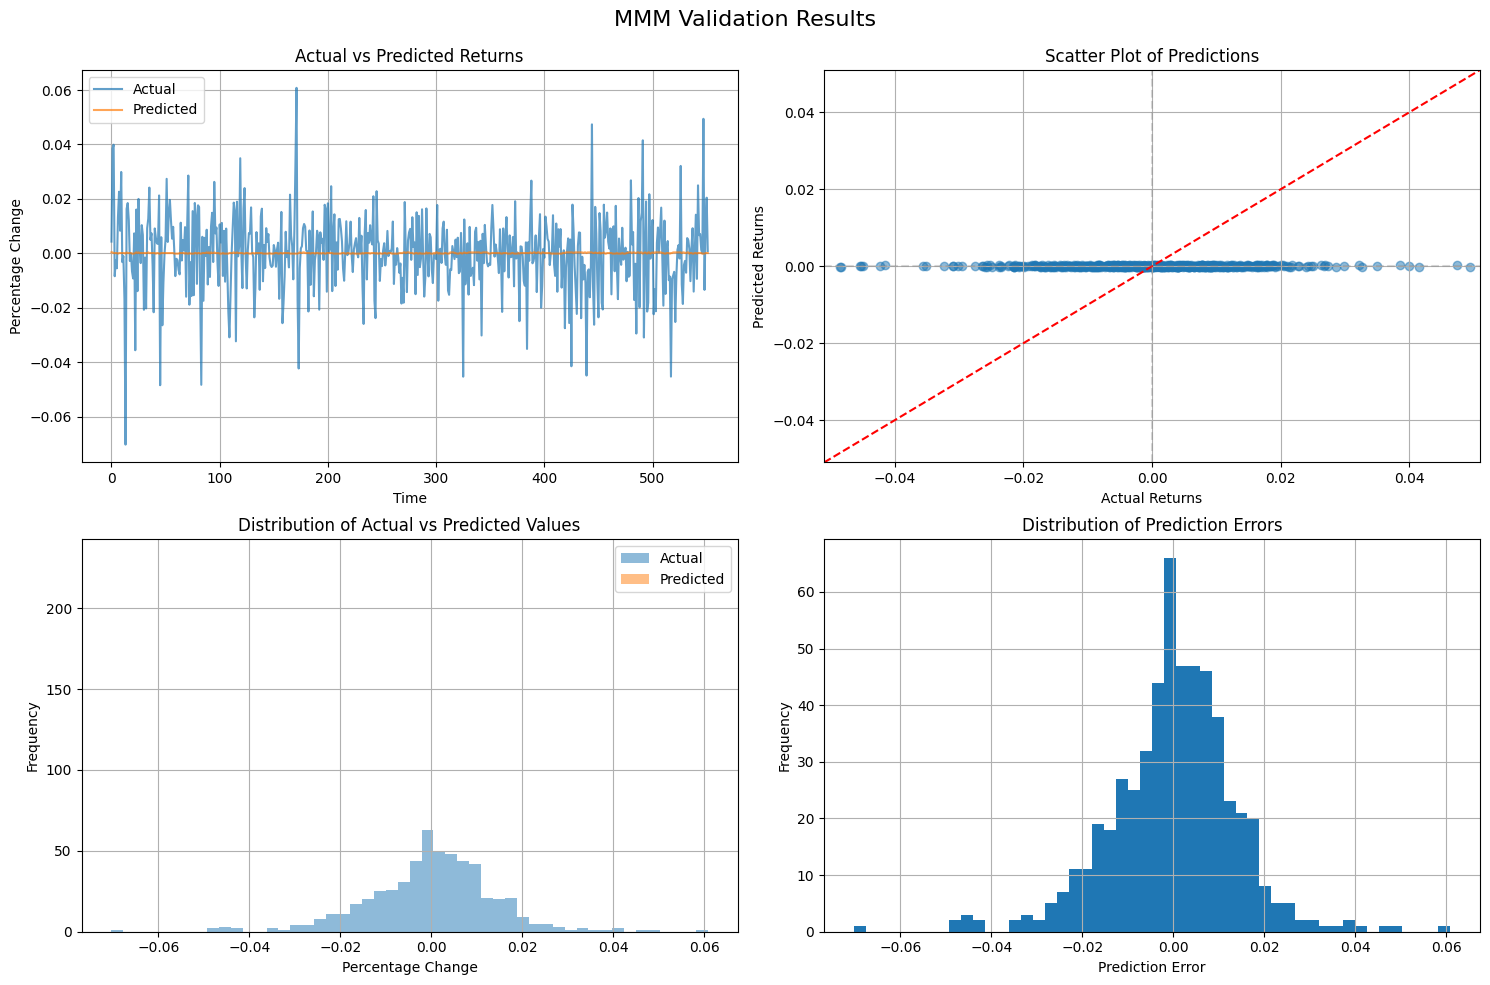

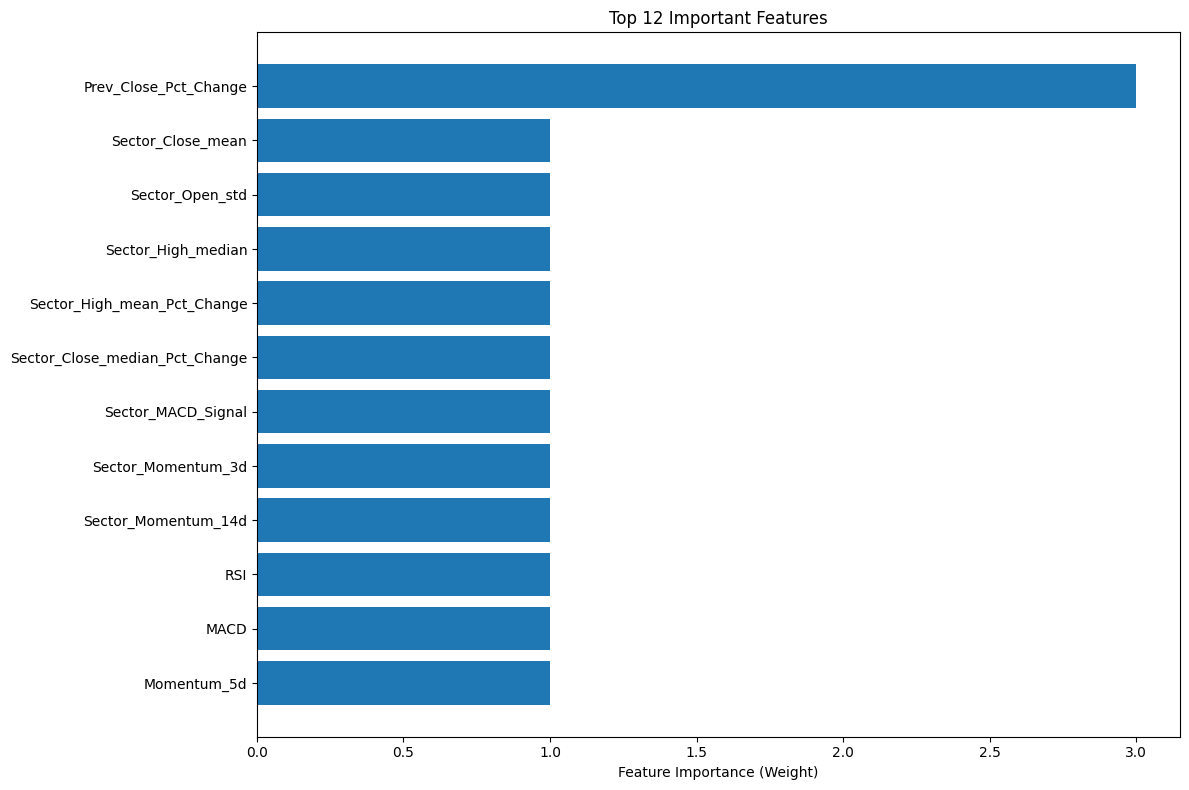


Evaluating on test set...

Model Performance Metrics:
MSE: 0.0004
RMSE: 0.0197
MAE: 0.0124
R2: -0.0006
Direction_Accuracy: 50.9058


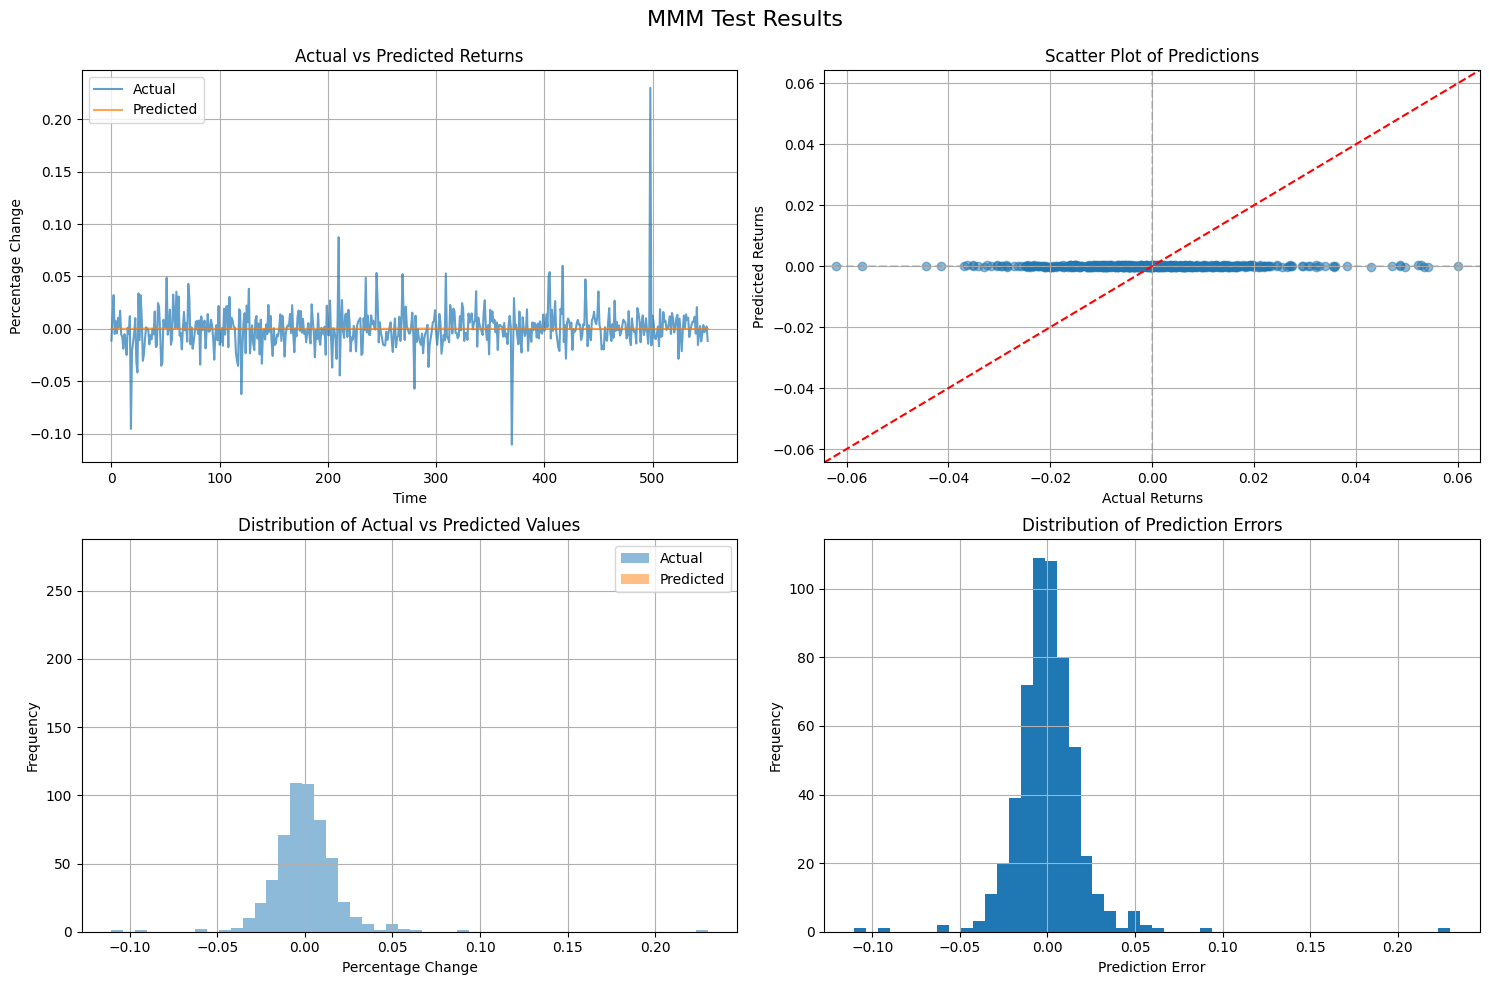


Sector features total importance: 8.00
Individual features total importance: 6.00
Ratio of sector to individual importance: 1.33


========== FINAL COMPARISON ==========
Metric               Balanced+Tuned  Balanced+Untuned Original+Tuned 
-----------------------------------------------------------------
Direction_Accuracy   52.5362         52.5362         51.9928        
RMSE                 0.0140          0.0140          0.0140         
MAE                  0.0103          0.0103          0.0102         
R2                   -0.0001         -0.0000         0.0009         


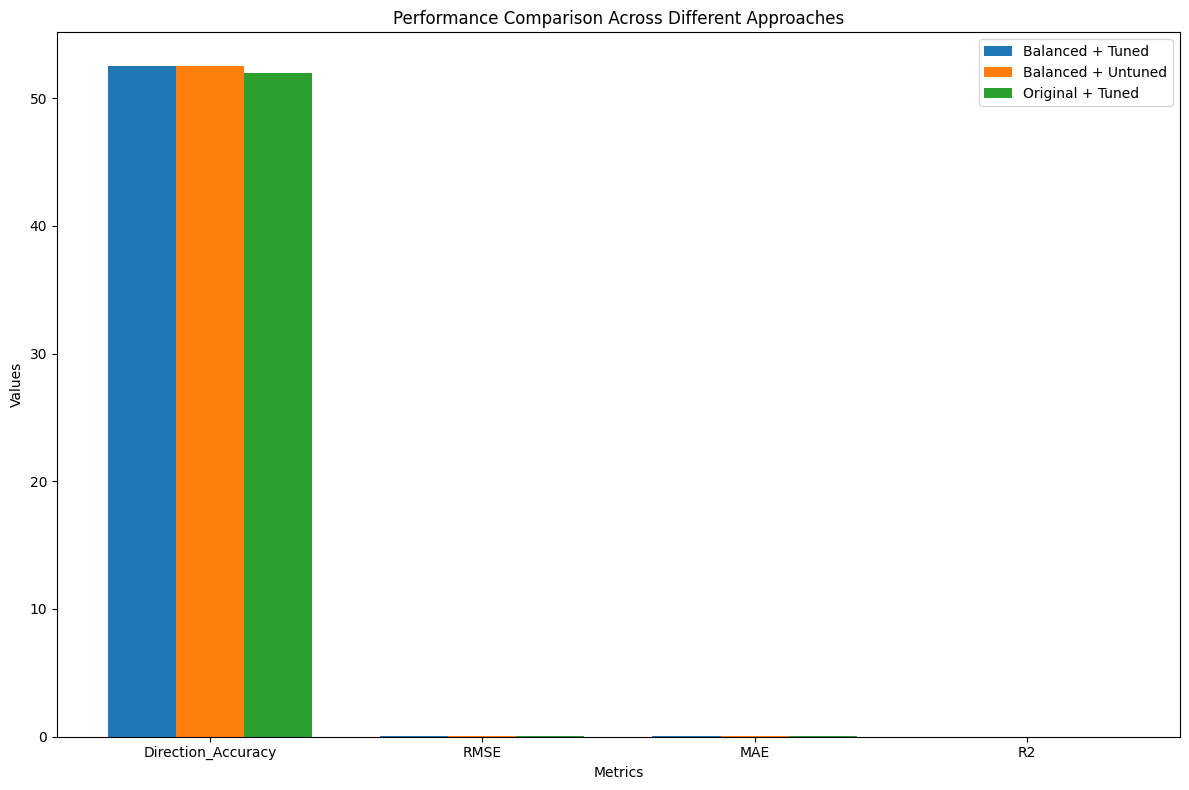

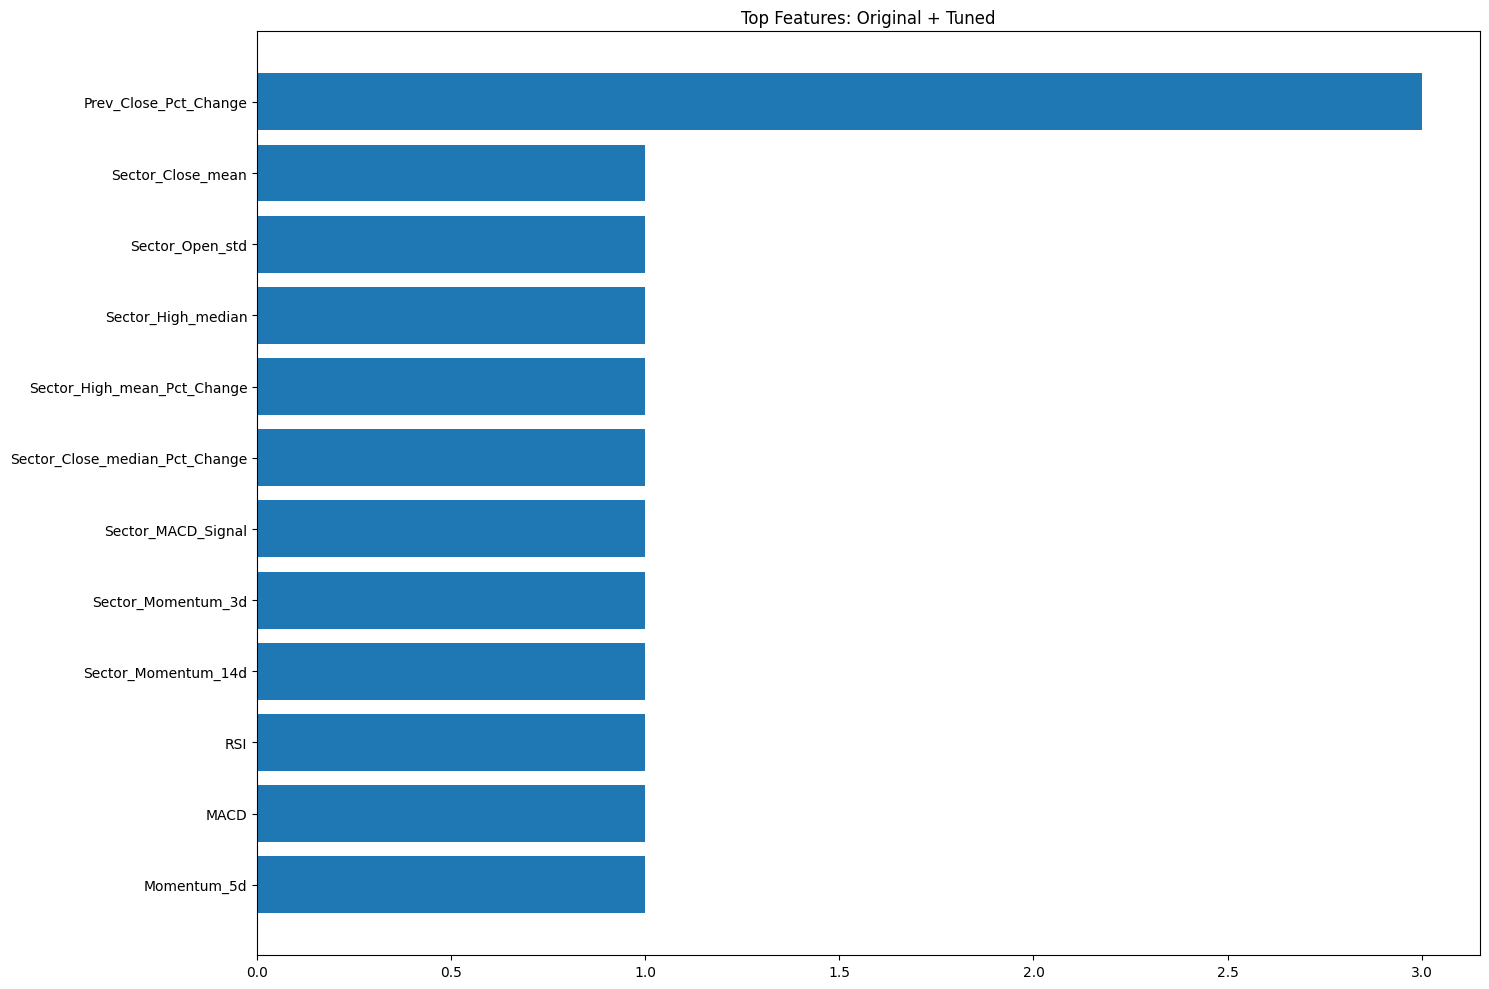


Best Parameters for Balanced + Tuned:
max_depth: 1
eta: 0.01
objective: reg:squarederror
eval_metric: rmse
subsample: 0.6
colsample_bytree: 0.6
alpha: 1
lambda: 1

Best Parameters for Original + Tuned:
max_depth: 3
eta: 0.3
objective: reg:squarederror
eval_metric: rmse
subsample: 0.7
colsample_bytree: 0.9
alpha: 1
lambda: 1


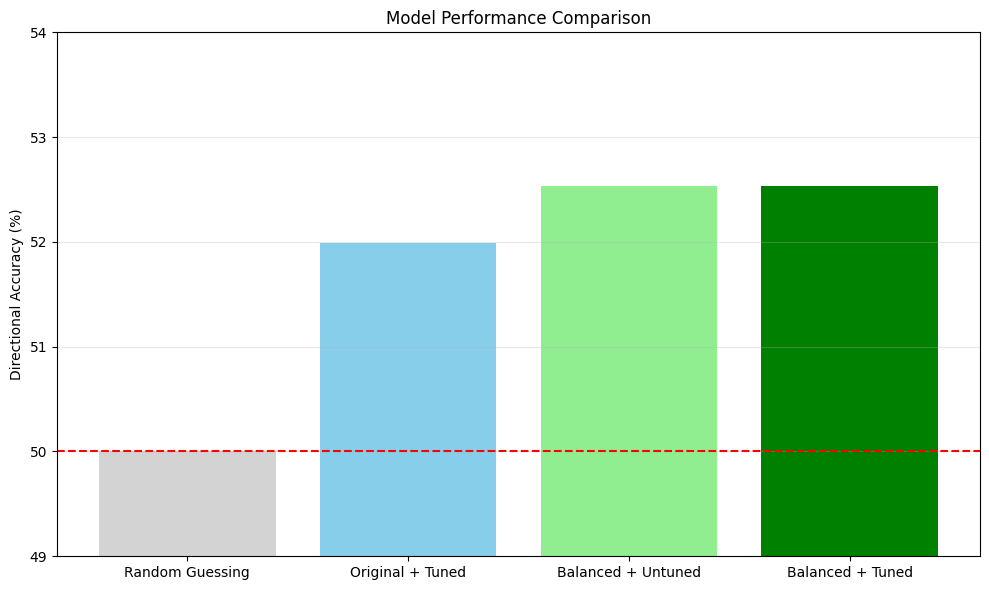

In [9]:
def main():
    """
    Run the balanced sector-based stock prediction model for MMM
    """
    # Load datasets
    print("Loading data...")

    # Load stock data
    stocks_df = pd.read_csv('/content/drive/MyDrive/Spring 2025/MATH-3439/Project2/sp500_stocks.csv')

    # Convert Date column to datetime
    stocks_df['Date'] = pd.to_datetime(stocks_df['Date'], errors='coerce')

    # Load companies data with sector information
    companies_df = pd.read_csv('/content/drive/MyDrive/Spring 2025/MATH-3439/Project2/sp500_companies.csv')

    # Make sure 'Symbol' columns are string type for merging
    stocks_df['Symbol'] = stocks_df['Symbol'].astype(str)
    companies_df['Symbol'] = companies_df['Symbol'].astype(str)

    # Run experiments with different approaches
    target_symbol = 'MMM'

    # Experiment 1: Balanced bins with hyperparameter tuning
    print("\n\n========== EXPERIMENT 1: BALANCED BINS WITH HYPERPARAMETER TUNING ==========")
    results_balanced_tuned = run_sector_based_prediction_with_balanced_data(
        stocks_df,
        companies_df,
        target_symbol,
        use_balanced_bins=True,
        n_bins=5,  # 5 bins for percentage change ranges
        samples_per_bin=100,  # 100 samples per bin
        tune_hyperparameters=True
    )

    # Experiment 2: Balanced bins without hyperparameter tuning
    print("\n\n========== EXPERIMENT 2: BALANCED BINS WITHOUT HYPERPARAMETER TUNING ==========")
    results_balanced_untuned = run_sector_based_prediction_with_balanced_data(
        stocks_df,
        companies_df,
        target_symbol,
        use_balanced_bins=True,
        n_bins=5,
        samples_per_bin=100,
        tune_hyperparameters=False  # Use default parameters
    )

    # Experiment 3: Original data distribution with hyperparameter tuning
    print("\n\n========== EXPERIMENT 3: ORIGINAL DISTRIBUTION WITH HYPERPARAMETER TUNING ==========")
    results_orig_tuned = run_sector_based_prediction_with_balanced_data(
        stocks_df,
        companies_df,
        target_symbol,
        use_balanced_bins=False,  # Use original data distribution
        tune_hyperparameters=True
    )

    # Compare all approaches
    print("\n\n========== FINAL COMPARISON ==========")
    comparison = {
        "Balanced + Tuned": results_balanced_tuned['validation_results']['Metrics'],
        "Balanced + Untuned": results_balanced_untuned['validation_results']['Metrics'],
        "Original + Tuned": results_orig_tuned['validation_results']['Metrics']
    }

    # Create a comparison table
    metrics_to_compare = ['Direction_Accuracy', 'RMSE', 'MAE', 'R2']

    print(f"{'Metric':<20} {'Balanced+Tuned':<15} {'Balanced+Untuned':<15} {'Original+Tuned':<15}")
    print("-" * 65)

    for metric in metrics_to_compare:
        balanced_tuned = comparison["Balanced + Tuned"][metric]
        balanced_untuned = comparison["Balanced + Untuned"][metric]
        orig_tuned = comparison["Original + Tuned"][metric]

        print(f"{metric:<20} {balanced_tuned:<15.4f} {balanced_untuned:<15.4f} {orig_tuned:<15.4f}")

    # Create visualization of performance comparison
    plt.figure(figsize=(12, 8))

    x = np.arange(len(metrics_to_compare))
    width = 0.25

    # Create bars
    plt.bar(x - width, [comparison["Balanced + Tuned"][m] for m in metrics_to_compare],
           width=width, label='Balanced + Tuned')
    plt.bar(x, [comparison["Balanced + Untuned"][m] for m in metrics_to_compare],
           width=width, label='Balanced + Untuned')
    plt.bar(x + width, [comparison["Original + Tuned"][m] for m in metrics_to_compare],
           width=width, label='Original + Tuned')

    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.title('Performance Comparison Across Different Approaches')
    plt.xticks(x, metrics_to_compare)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Visualize feature importance across methods
    plt.figure(figsize=(15, 10))

    # Check if feature importance dataframes exist and have content
    has_balanced_tuned = not results_balanced_tuned['feature_importance'].empty if 'feature_importance' in results_balanced_tuned else False
    has_balanced_untuned = not results_balanced_untuned['feature_importance'].empty if 'feature_importance' in results_balanced_untuned else False
    has_orig_tuned = not results_orig_tuned['feature_importance'].empty if 'feature_importance' in results_orig_tuned else False

    # Adjust number of subplots based on available data
    num_plots = sum([has_balanced_tuned, has_balanced_untuned, has_orig_tuned])
    if num_plots == 0:
        print("No feature importance data available to plot.")
    else:
        current_plot = 1

        # Plot feature importance comparison
        if has_balanced_tuned:
            plt.subplot(num_plots, 1, current_plot)
            plt.barh(results_balanced_tuned['feature_importance']['Feature'][::-1],
                   results_balanced_tuned['feature_importance']['Importance'][::-1])
            plt.title('Top Features: Balanced + Tuned')
            current_plot += 1

        if has_balanced_untuned:
            plt.subplot(num_plots, 1, current_plot)
            plt.barh(results_balanced_untuned['feature_importance']['Feature'][::-1],
                   results_balanced_untuned['feature_importance']['Importance'][::-1])
            plt.title('Top Features: Balanced + Untuned')
            current_plot += 1

        if has_orig_tuned:
            plt.subplot(num_plots, 1, current_plot)
            plt.barh(results_orig_tuned['feature_importance']['Feature'][::-1],
                   results_orig_tuned['feature_importance']['Importance'][::-1])
            plt.title('Top Features: Original + Tuned')

        plt.tight_layout()
        plt.show()

    # Show best parameters if tuning was performed
    if 'best_params' in results_balanced_tuned and results_balanced_tuned['best_params']:
        print("\nBest Parameters for Balanced + Tuned:")
        for param, value in results_balanced_tuned['best_params'].items():
            print(f"{param}: {value}")

    if 'best_params' in results_orig_tuned and results_orig_tuned['best_params']:
        print("\nBest Parameters for Original + Tuned:")
        for param, value in results_orig_tuned['best_params'].items():
            print(f"{param}: {value}")

# Create directional accuracy chart
    try:
        directional_accuracy = {
            "Original + Tuned": comparison["Original + Tuned"]["Direction_Accuracy"],
            "Balanced + Untuned": comparison["Balanced + Untuned"]["Direction_Accuracy"],
            "Balanced + Tuned": comparison["Balanced + Tuned"]["Direction_Accuracy"]
        }
        plot_directional_accuracy_comparison(directional_accuracy)
    except Exception as e:
        print(f"Visualization error (non-critical): {e}")

    return {
        "results_balanced_tuned": results_balanced_tuned,
        "results_balanced_untuned": results_balanced_untuned,
        "results_orig_tuned": results_orig_tuned
    }



if __name__ == "__main__":
    main()